# Pre-Process
## Packages 

In [1]:
import yfinance as yf               # get stocks data
import pandas   as pd               # manipulate dataframes
import mplfinance as mpf            # plot stock charts
import matplotlib.pyplot as plt     # plot custom charts
import numpy as np                  # math functions
import talib as ta                  # calculate moving averages SMA
from datetime import timedelta      # add days to dates
from IPython.display import HTML    # code in HTML

## Functions

### Simplify df_stock

In [2]:
def simplify_df(df_in, bo_Date_is_index=True) :
    '''
    Simplifies a multi-index DataFrame & optionally resets the index.

    Args:
        df_in (pd.DataFrame):    input DataFrame from yfinance download
        bo_Date_is_index (bool): If True (default), keeps 'Date' as row index
                                 If False, replaces row index ('Date' by new 'Id')

    Returns:
        pd.DataFrame: DataFrame with simplified structure & optionally new index
    '''    
    # Characteristics of df_in
    print('Column indexes of df_in  : ', df_in.columns.names)
    print('Row indexes    of df_in  : ', df_in.index.name)

    # Convert float values to integer
    df_out = df_in.copy()
    df_out = df_out.astype('int')

    # Remove 1st level of column names
    li_new_columns = list(df_in.columns.get_level_values(0))
    df_out.columns = li_new_columns
    
    # Optional : Replace index Date -> Id
    if not bo_Date_is_index :
        df_out = df_out.reset_index()
        df_out.index.name = 'Id'

    # Characteristics of df_out
    print('Column names   of df_out : ', df_out.columns)
    print('Row indexes    of df_out : ', df_out.index.name)
    
    return df_out

### Plot Candlesticks Chart

In [5]:
# interactive plots != inline
%matplotlib ipympl  

In [6]:
def get_subset_to_plot(df_in, max_nb_trades=599) :
    if len(df_in) >= 600 :
        max_nb_trades  # <600 to avoid "Too much data" warning
        df_subset = df_in.tail(max_nb_trades)  # only last 600 trades are plotted 
        return df_subset
    else :
        return df_in

In [60]:
def plot_chart(df_in, s_title, li_mav=[], li_addplots=[], bo_add_Volume=True, i_width=12, i_height=5, bo_show_legend=False) :
    '''
    Plots a candlestick chart with optional Volume.

    Args:
        df_in (pd.DataFrame): input DataFrame with index Date and columns Open, High, Low, Close, Volume
        s_title (str): chart's title
        bo_add_Volume (bool, optional): If True (default), adds a volume subplot
    '''
    df_subset = get_subset_to_plot(df_in)
    fig, axes = mpf.plot(df_subset, type='candle', title=s_title, volume=bo_add_Volume, figsize=(i_width, i_height), 
                        mav=li_mav,           # moving average curves             
                        addplot=li_addplots,  # append other curves in current or additional panels 
                        style='yahoo',        # other styles: binance, nightclouds
                        returnfig=True        # allows to return axes
                )
    if bo_show_legend :
        axes[1].set_yticks([])
        axes[1].legend(loc='upper left')
    plt.show()
    plt.close()

In [8]:
def append_macd (df_in, bo_add_Volume, li_addplots=[]) :
    '''
    Calculates 3 indicators (MACD Signal lines + MACD Histogram) and appends them to a list.

    Args:
        df_in (pd.DataFrame): input DataFrame with index Date and columns Open, High, Low, Close, Volume
        bo_add_MACD   (bool, optional): If True (default), adds 
    '''
    # Calculate MACD (trend of a trend) 
    # with ewm() = Exponential Weighted Moving average
    df_fast_average = df_in['Close'].ewm(span=12, adjust=False).mean() 
    df_slow_average = df_in['Close'].ewm(span=26, adjust=False).mean()
    df_fast_trend   = df_fast_average - df_slow_average
    df_slow_trend   = df_fast_trend.ewm(span=9, adjust=False).mean()
    df_trend_of_trend = df_fast_trend - df_slow_trend
    df_in.loc[:, 'MACD']   = df_slow_trend
    df_in.loc[:, 'Signal'] = df_fast_trend
    df_in.loc[:, 'Hist_pos'] = df_trend_of_trend.map(lambda x: x if x > 0 else 0)
    df_in.loc[:, 'Hist_neg'] = df_trend_of_trend.map(lambda x: x if x < 0 else 0)

    # Append MACD curves to chart 
    df_subset = get_subset_to_plot(df_in)  # only last 600 trades are plotted 
    if bo_add_Volume :  hist_panel = 2
    else             :  hist_panel = 1
    signal_panel = hist_panel + 1
    li_addplots = [        
        mpf.make_addplot(df_subset[['Hist_pos']], type='bar',  panel=hist_panel,   ylabel='Histogram', color='green'),
        mpf.make_addplot(df_subset[['Hist_neg']], type='bar',  panel=hist_panel,   ylabel='Histogram', color='red'),
        mpf.make_addplot(df_subset[['MACD']]    , type='line', panel=signal_panel, ylabel='MACD', color='gray', label='MACD'),
        mpf.make_addplot(df_subset[['Signal']]  , type='line', panel=signal_panel, ylabel='Signal', color='orange')
    ]
    return li_addplots

In [9]:
def plot_pattern_sample(li_dates, s_pattern, delta=5) : 
    # dates range = d_last_occurrence +- delta
    d_last_occurrence = li_dates[-1]
    print('d_last_occurrency ' + s_pattern, d_last_occurrence)
    t_delta = timedelta(days=delta)
    d_start = d_last_occurrence - t_delta
    d_end   = d_last_occurrence + t_delta
    df_subset = df_simpler.loc[d_start : d_end]
    plot_chart(df_subset, 'Last Occurrency of ' + s_pattern, li_mav=[], li_addplots=[], bo_add_Volume=False, i_width=7, i_height=2)

In [10]:
def append_pattern(df_in, s_pattern, s_color) :
    df_subset = get_subset_to_plot(df_in)
    return mpf.make_addplot(df_subset[[s_pattern]], type='bar', color=s_color, alpha=0.3, label=s_pattern)

In [11]:
def plot_pattern_full(df_in, s_pattern, li_mav=[], bo_volume=False, i_width=15, i_height=5, s_color='cyan') :
    s_title = s_pattern + ' on chart'
    li_addplots = [ append_pattern(df_in, s_pattern, s_color) ]
    plot_chart(df_in, s_title, li_mav, li_addplots, bo_volume, i_width, i_height)

### Candlesticks

In [12]:
li_main_prices = ['Open', 'Close', 'High', 'Low'] 

#### Get Dimensions of a Candle 

In [13]:
def get_candle_dims(trade) :
    open_, close, high, low = trade[li_main_prices]
    body       = abs(open_         - close) 
    range_     = high              - low
    upper_wick = high              - max(close, open_)
    lower_wick = min(close, open_) - low
    return body, range_, upper_wick, lower_wick

#### Get Top & Bottom of all candles' bodies 

In [14]:
def get_body_top   (df_in) : 
    return np.maximum(df_in['Open'] , df_in['Close']) # get max value from 2 DF columns 

def get_body_bottom(df_in) :      
    return np.minimum(df_in['Open'] , df_in['Close']) # get min value from 2 DF columns

### Candlestick Patterns

#### Doji

In [15]:
def is_doji(trade) : # A Doji's body is much smaller than its range
    body, range_, _, _     = get_candle_dims(trade)
    ratio_body_range = 0.1
    bo_is_doji = ( body <= ratio_body_range * range_ )
    return bo_is_doji

<img src='https://img.investingoal.com/app/uploads/2024/11/long-legged-doji-candlestick-pattern.jpg' width='400px'>

#### Inverted Hammer

In [16]:
def is_inv_hammer(trade) : # An Inverse Hammer's body is very close to its Low
    body, _, upper_wick, lower_wick = get_candle_dims(trade)
    ratio_up_wick_body = 2
    ratio_lo_wick_body = 0.1
    bo_is_inv_hammer = ( ( upper_wick >= ratio_up_wick_body * body ) and
                         ( lower_wick <= ratio_lo_wick_body * body ) )
    return bo_is_inv_hammer

<img src='https://media.assettype.com/tnm/import/sites/default/files/images/image1%20(2)(5).png' width='400px'>

#### Hammer

In [17]:
def is_hammer(trade) : # A Hammer's body is very close to its High
    body, _, upper_wick, lower_wick = get_candle_dims(trade)
    ratio_up_wick_body = 0.1
    ratio_lo_wick_body = 2
    bo_is_hammer = ( ( upper_wick <= ratio_up_wick_body * body ) and
                     ( lower_wick >= ratio_lo_wick_body * body ) )
    return bo_is_hammer

<img src='https://ninjatrader.com/getattachment/5e35b7c2-7054-4f8a-8356-f2efc79202f9/bullish-hammer-image.png' width='400px'>

#### Bullish/Bearish Engulfing

In [18]:
def get_curr_prev_dfs(df_in) :
    # Create 2 DFs to compare columns rather than pairs of consecutive records
    df_curr = df_in[li_main_prices].copy()
    df_prev = df_curr.shift(1)
    df_prev = df_prev.iloc[1:].astype('int')
    df_curr = df_curr.iloc[1:]
    return df_curr, df_prev

In [19]:
def is_bull_bear_engulf(df_curr, df_prev) :
    # Get series of Engulfing Candles
    se_high_increased   = ( df_curr['High']          > df_prev['High'] )
    se_low_decreased    = ( df_prev['Low']           > df_curr['Low'] )
    se_top_increased    = ( get_body_top   (df_curr) > get_body_top   (df_prev) )
    se_bottom_decreased = ( get_body_bottom(df_prev) > get_body_bottom(df_curr) )
    se_engulfing        = se_high_increased & se_low_decreased & se_top_increased & se_bottom_decreased

    # Get series of Bullish Candles (current & previous)
    se_prev_bullish     = ( df_prev['Close']      > df_prev['Open'] ) 
    se_curr_bullish     = ( df_curr['Close']      > df_curr['Open'] )    
    
    se_bullish_engulf   = ( se_engulfing & se_curr_bullish     & ~se_prev_bullish ) # Get series of Bullish Engulfings
    se_bearish_engulf   = ( se_engulfing & ~se_curr_bullish    &  se_prev_bullish ) # Get series of Bearish Engulfings

    return se_bullish_engulf, se_bearish_engulf

<img src='https://fxpipsgainer.com/wp-content/uploads/2022/03/Bullish-and-Bearish-Engulfing.png' width='400px'> 

#### Crossing Curves

<img src='https://aximedia.s3.amazonaws.com/rebrand-prod/rpfccnxi/how-to-understand-moving-average.png'  width='500px'>

##### Get crossing points of 2 curves

In [20]:
def get_crossings(sr_short, sr_long) :
    sr_short_prev      = sr_short.shift(1)              # get Short previous values
    sr_prev_was_lower  = ( sr_short_prev <= sr_long )   # before crossing
    sr_prev_was_higher = ~sr_prev_was_lower
    sr_curr_is_higher  = ( sr_short      >= sr_long )   # after  crossing
    sr_curr_is_lower   = ~sr_curr_is_higher
    sr_cross_above     = ( sr_prev_was_lower  & sr_curr_is_higher )
    sr_cross_below     = ( sr_prev_was_higher & sr_curr_is_lower )
    return remove_trailing_Trues(sr_cross_above), remove_trailing_Trues(sr_cross_below)

##### Remove trailing True values from DF

In [21]:
def remove_trailing_Trues(sr_in) :
    sr_prev = sr_in.shift(1)            # get previous values
    d_1st_trade = sr_prev.index[0]      # replaces deprecated fillna
    sr_prev.loc[d_1st_trade] = False    # replace first row NaN to False
    sr_prev = sr_prev.astype(bool)
    sr_out = sr_in & ~sr_prev
    sr_out.loc[d_1st_trade] = False     # replace first row NaN to False
    return sr_out

# Main Process

## Load

In [22]:
s_stock_ref   = '^NSEI' # Nifty 50
s_interval    = '1d'    # valid values : 1 2 5 15 30 60 90m 1h 1 5d 1wk 1 3mo

### Specific period between 2 dates

### Specific duration of period

In [23]:
s_period  = '5y' # valid values : 1 5d 1 3 6mo 1 2 5 10y ytd max 
df_stocks = yf.download(s_stock_ref, interval=s_interval, period=s_period)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Format

In [24]:
df_simpler = simplify_df(df_stocks) #, False)

Column indexes of df_in  :  ['Price', 'Ticker']
Row indexes    of df_in  :  Date
Column names   of df_out :  Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Row indexes    of df_out :  Date


In [25]:
df_simpler.head(1)

,Close,High,Low,Open,Volume
Date,,,,,
2020-06-25,10288,10361,10194,10235,994200


## Visualise
### Plot Chart

In [26]:
li_addplots = []

C:\Users\Jean\AppData\Local\Temp\ipykernel_3020\2271229112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.loc[:, 'MACD']   = df_slow_trend
C:\Users\Jean\AppData\Local\Temp\ipykernel_3020\2271229112.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.loc[:, 'Signal'] = df_fast_trend
C:\Users\Jean\AppData\Local\Temp\ipykernel_3020\2271229112.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

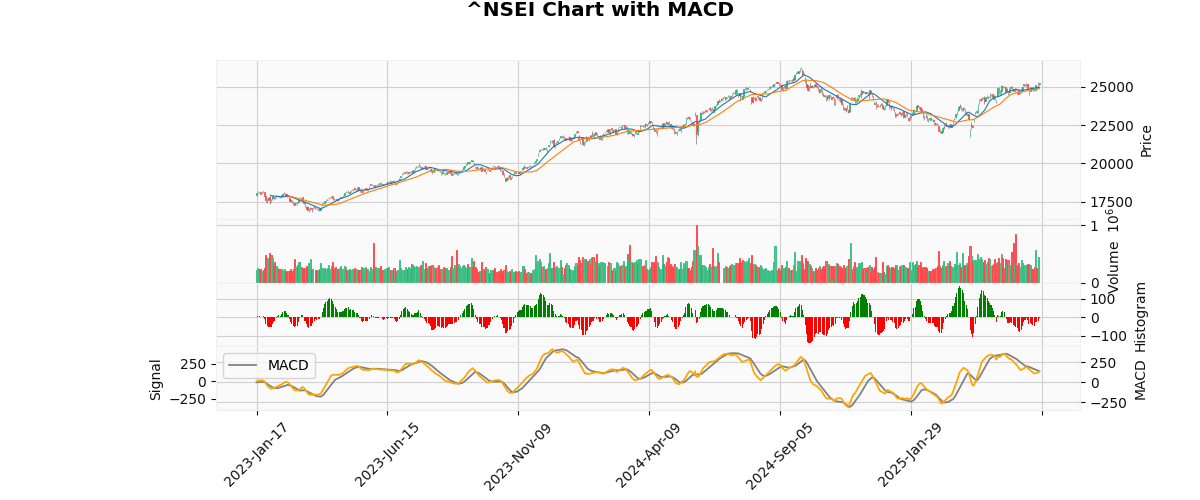

In [27]:
s_title       = s_stock_ref + ' Chart with MACD'
li_mav        = [12, 26]
bo_add_Volume = True
df_subset     = get_subset_to_plot(df_simpler)
li_addplots   = append_macd(df_subset, bo_add_Volume)
plot_chart(df_simpler, s_title, li_mav, li_addplots, bo_add_Volume=bo_add_Volume, bo_show_legend=False)

## Pattern Detection

### Candlesticks

#### Append 1 DF column per pattern

In [28]:
df_simpler['Doji']      = df_simpler.apply(is_doji,       axis=1) # 1: applies to rows
df_simpler['InvHammer'] = df_simpler.apply(is_inv_hammer, axis=1)
df_simpler['Hammer']    = df_simpler.apply(is_hammer,     axis=1)

In [29]:
# Append column InvHammer
df_simpler['Hammer'] = df_simpler.apply(is_hammer, axis=1) # 1: applies to rows

In [30]:
li_hammer_dates = df_simpler[df_simpler['Hammer']].index.to_list()
li_hammer_dates

[Timestamp('2021-06-18 00:00:00'),
 Timestamp('2022-08-10 00:00:00'),
 Timestamp('2023-03-20 00:00:00'),
 Timestamp('2023-04-03 00:00:00'),
 Timestamp('2024-06-03 00:00:00'),
 Timestamp('2025-01-08 00:00:00'),
 Timestamp('2025-04-15 00:00:00'),
 Timestamp('2025-04-23 00:00:00')]

##### Bullish/Bearish Engulfing

In [31]:
# Create 2 DFs to compare 2 consecutive records
df_curr, df_prev = get_curr_prev_dfs(df_simpler) 
print('\nPrevious\n', df_prev.head(2))
print('\nCurrent\n',  df_curr.head(2))


Previous
              Open  Close   High    Low
Date                                  
2020-06-26  10235  10288  10361  10194
2020-06-29  10378  10383  10409  10311

Current
              Open  Close   High    Low
Date                                  
2020-06-26  10378  10383  10409  10311
2020-06-29  10311  10312  10337  10223


In [32]:
# Append as columns 2 series of occurrencies of Bullish & Bearish Engulfings
df_simpler['BullEngulf'] , df_simpler['BearEngulf'] = is_bull_bear_engulf(df_curr, df_prev)

In [33]:
# Replace by False the NaN values of the Engulfing flags of the 1st trade 
d_1st_trade = df_simpler.index[0] 
df_simpler.loc[d_1st_trade, ['BullEngulf', 'BearEngulf']] = False
df_simpler[li_main_prices + ['BullEngulf', 'BearEngulf']].head(2)

,Open,Close,High,Low,BullEngulf,BearEngulf
Date,,,,,,
2020-06-25,10235,10288,10361,10194,False,False
2020-06-26,10378,10383,10409,10311,False,False


#### Plot most recent occurency per pattern

Doji : 128 ocurrencies
d_last_occurrency Doji 2025-06-19 00:00:00


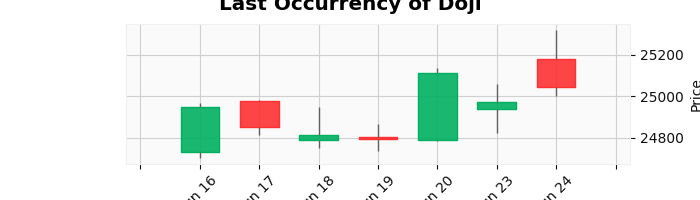

InvHammer : 4 ocurrencies
d_last_occurrency InvHammer 2025-05-09 00:00:00


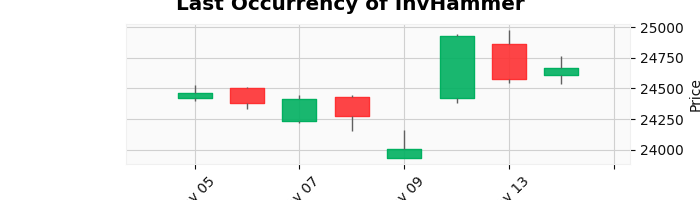

Hammer : 8 ocurrencies
d_last_occurrency Hammer 2025-04-23 00:00:00


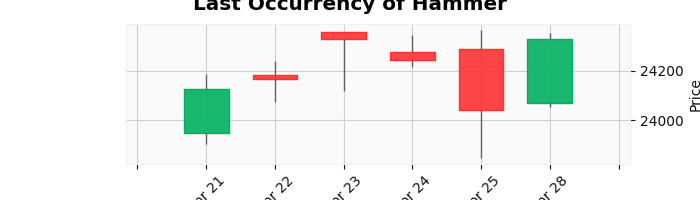

BullEngulf : 11 ocurrencies
d_last_occurrency BullEngulf 2024-12-13 00:00:00


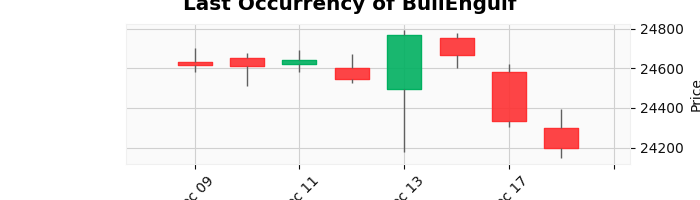

BearEngulf : 37 ocurrencies
d_last_occurrency BearEngulf 2025-06-03 00:00:00


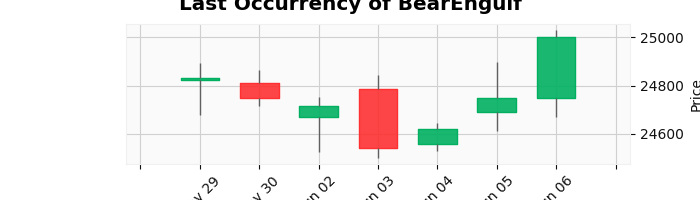

In [34]:
li_patterns = ['Doji', 'InvHammer', 'Hammer', 'BullEngulf', 'BearEngulf']
for s_pattern in li_patterns :
    li_dates = df_simpler[df_simpler[s_pattern]].index.to_list()
    print(s_pattern, ':', len(li_dates), 'ocurrencies')
    plot_pattern_sample(li_dates, s_pattern)

### Plot all patterns in a single chart

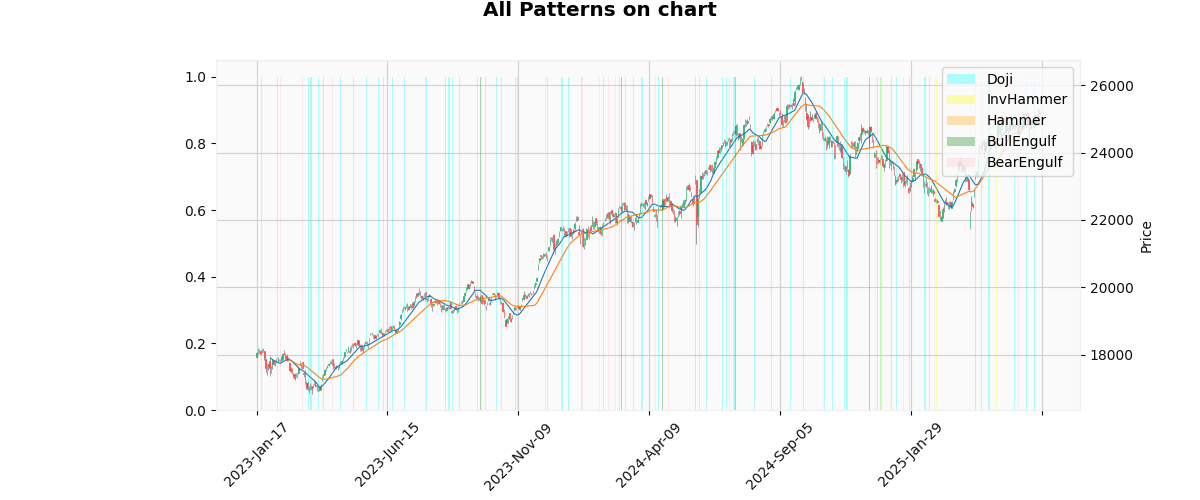

In [35]:
s_title       = 'All Patterns on chart'
li_mav        = [12, 26]
bo_add_Volume = False
li_addplots   = [   append_pattern(df_simpler, 'Doji',       'cyan'),
                    append_pattern(df_simpler, 'InvHammer',  'yellow'),
                    append_pattern(df_simpler, 'Hammer',     'orange'),
                    append_pattern(df_simpler, 'BullEngulf', 'green'),
                    append_pattern(df_simpler, 'BearEngulf', 'pink')
                ]
plot_chart(df_simpler, s_title, li_mav, li_addplots, bo_add_Volume=bo_add_Volume)

### Plot 1 pattern per chart

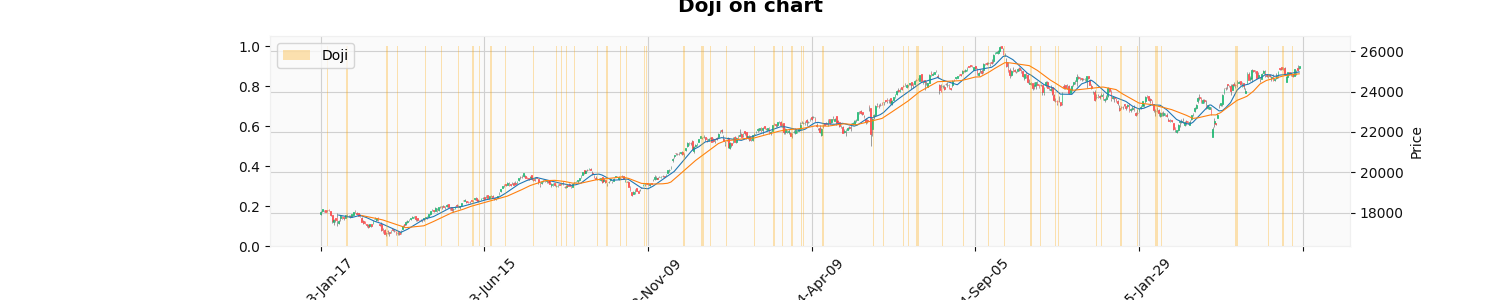

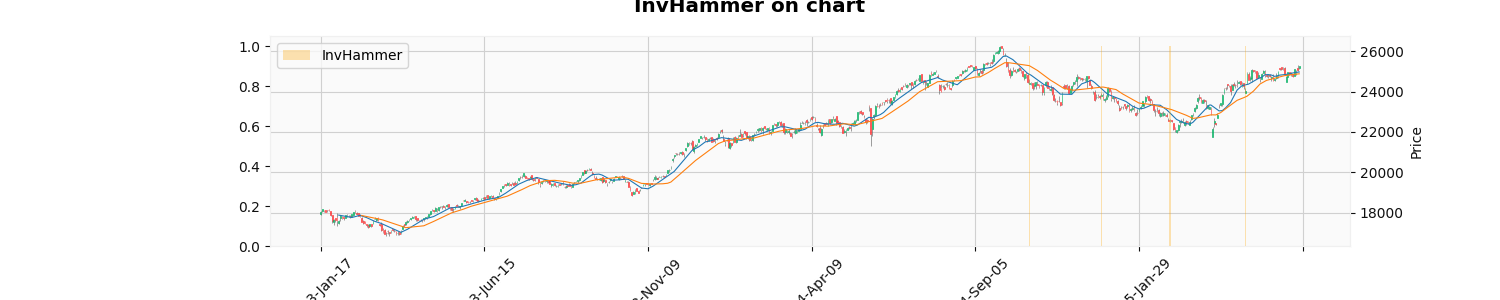

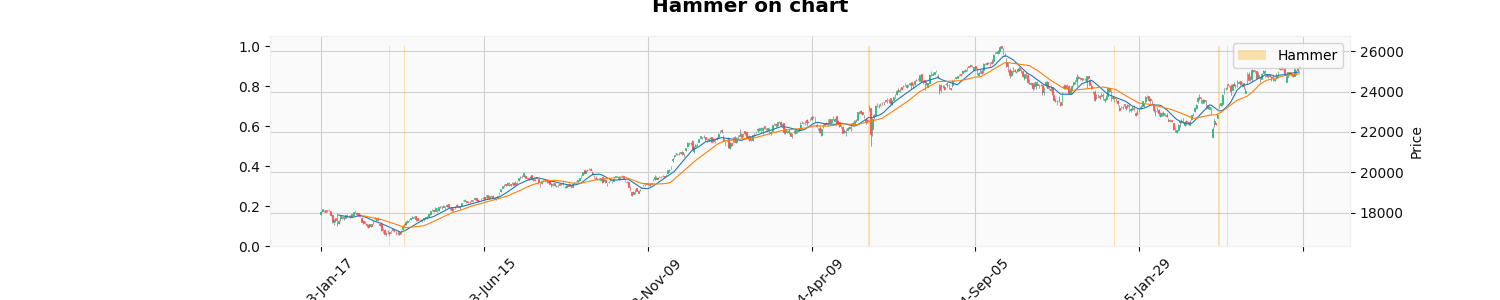

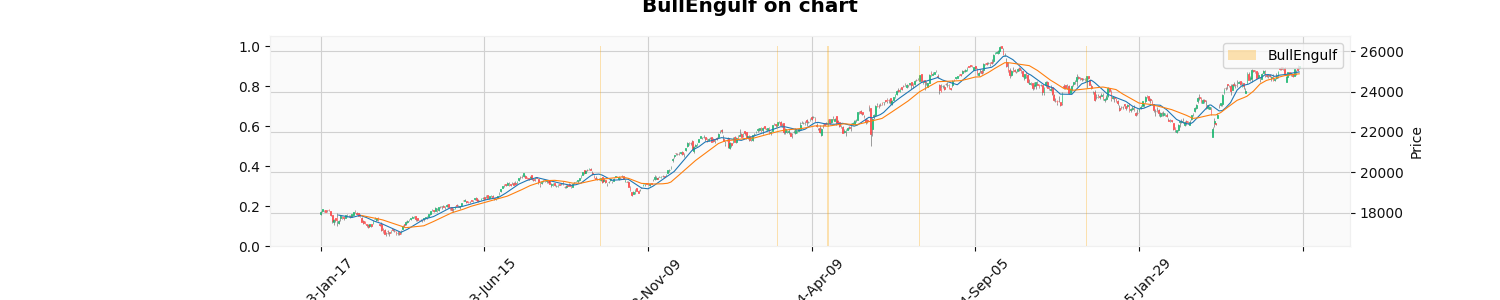

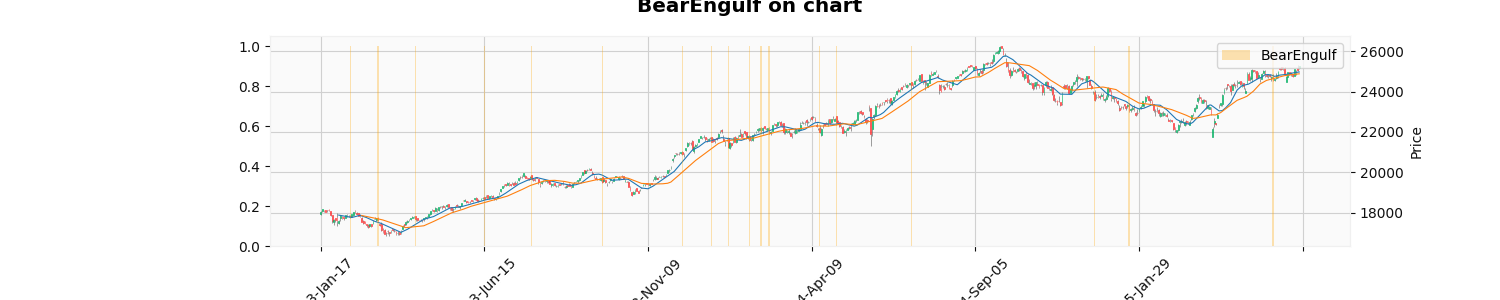

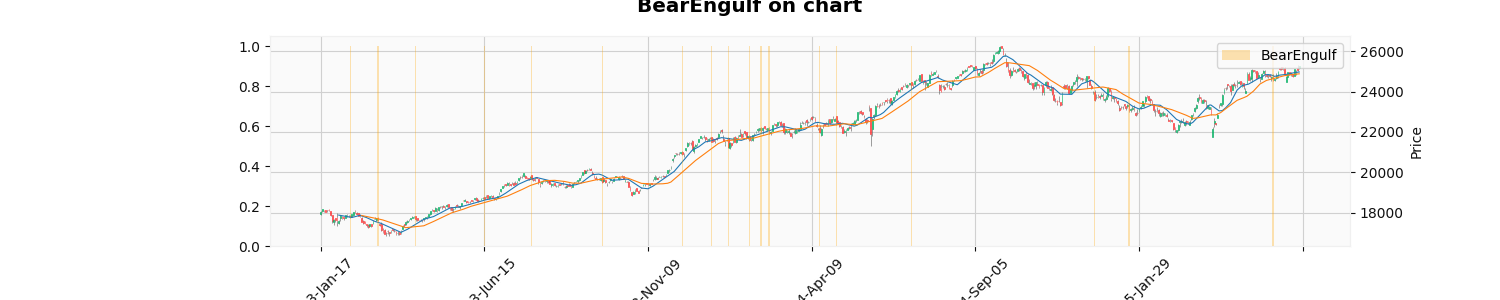

In [36]:
for s_pattern in ['Doji', 'InvHammer', 'Hammer', 'BullEngulf', 'BearEngulf'] :
    plot_pattern_full(df_simpler, s_pattern, li_mav, i_width=15, i_height=3, s_color='orange')
plt.show()

## Strategy

### Short & Long Period SMAs

In [37]:
i_short, i_long = 9, 17 # nb of days
sr_close = df_simpler['Close']
sr_long  = ta.SMA(sr_close, timeperiod=i_long)

### Strategy 1 - Closing Price vs. Long-Period SMA

#### Plot
Buy when Short-Term curve exceeds Long-Term and Sell when it subceeds

In [38]:
df_simpler['SMA_exceed'], df_simpler['SMA_subceed'] = get_crossings(sr_close, sr_long)

#### Plot
Buy when Short-Term curve exceeds Long-Term and Sell when it subceeds

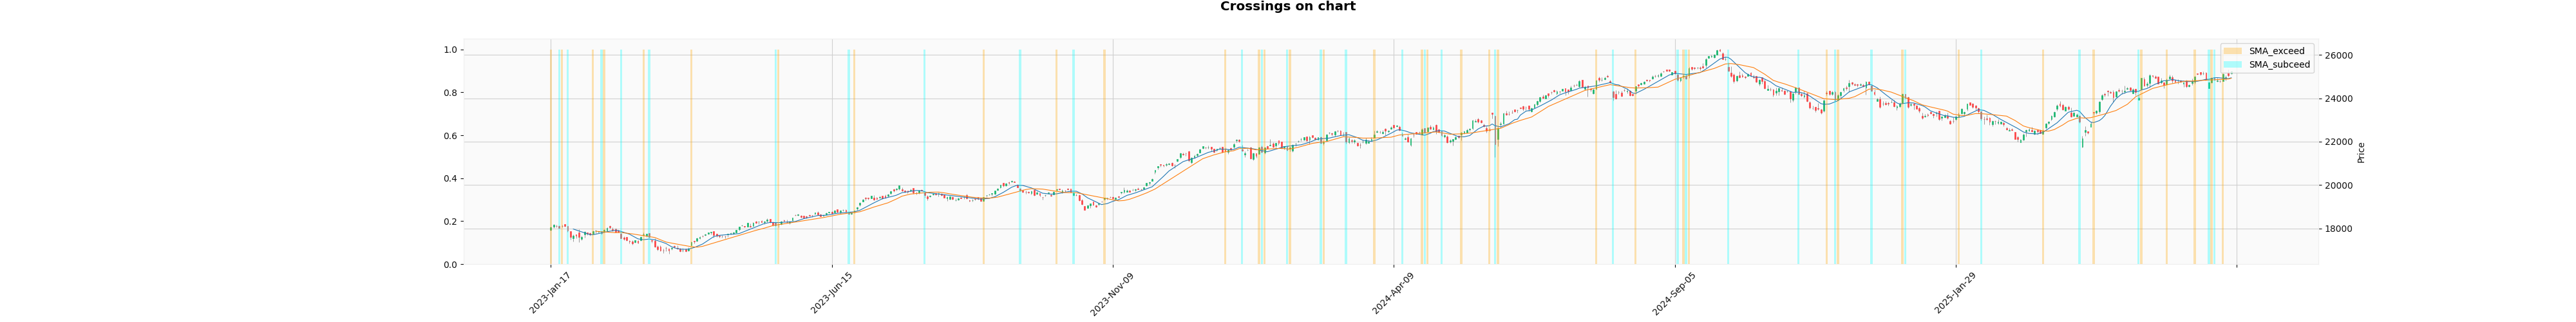

In [39]:
s_title     = 'Crossings on chart'
li_mav      = [i_short, i_long]
li_addplots = [   append_pattern(df_simpler, 'SMA_exceed',  'orange'),
                  append_pattern(df_simpler, 'SMA_subceed', 'cyan')
              ]
plot_chart(df_simpler, s_title, li_mav, li_addplots, bo_add_Volume=False, i_width=40, i_height=5)

In [40]:
def get_balance(df_in, s_col_price, s_col_buy, s_col_sell, bo_verbose=True) :
    # A single share is bought or sold per action
    ni_sold_qty      = df_in[s_col_sell].sum()  # ni stands for numpy.int64
    ni_bought_qty    = df_in[s_col_buy ].sum()
    ni_last_price    = df_in[s_col_price].iloc[-1]
    ni_current_total = ni_last_price * ( ni_bought_qty - ni_sold_qty)
    ni_sold_total   = ( df_in.loc[df_in[s_col_sell], s_col_price] * 1 ).sum()
    ni_bought_total = ( df_in.loc[df_in[s_col_buy],  s_col_price] * 1 ).sum()
    ni_balance      = ni_current_total + ni_sold_total - ni_bought_total
    if bo_verbose :
        print('sold_qty=', ni_sold_qty, 'bought_qty=', ni_bought_qty)
        print('current_total=', ni_current_total)
        print('last_price=', ni_last_price)
        print('sold_total=', ni_sold_total, 'bought_total=', ni_bought_total)    
    return int(ni_balance)   # casts np.int -> int

In [41]:
print('Balance=', get_balance(df_simpler, 'Close', 'SMA_exceed', 'SMA_subceed') )

sold_qty= 72 bought_qty= 79
current_total= 176708
last_price= 25244
sold_total= 1316846 bought_total= 1461014
Balance= 32540


### Strategy 2 - Short-Period SMA vs. Long-Period SMA

#### Short & Long Period SMAs

In [42]:
i_short, i_long = 8, 29 # nb of days
sr_close = df_simpler['Close']
sr_short = ta.SMA(sr_close, timeperiod=i_short)
sr_long  = ta.SMA(sr_close, timeperiod=i_long)

#### Crossings
Detects when Short-Term curve subceeds and exceeds Long-Term

In [43]:
df_simpler['SMA_exceed'], df_simpler['SMA_subceed'] = get_crossings(sr_short, sr_long)

#### Plot
Buy when Short-Term curve exceeds Long-Term and Sell when it subceeds

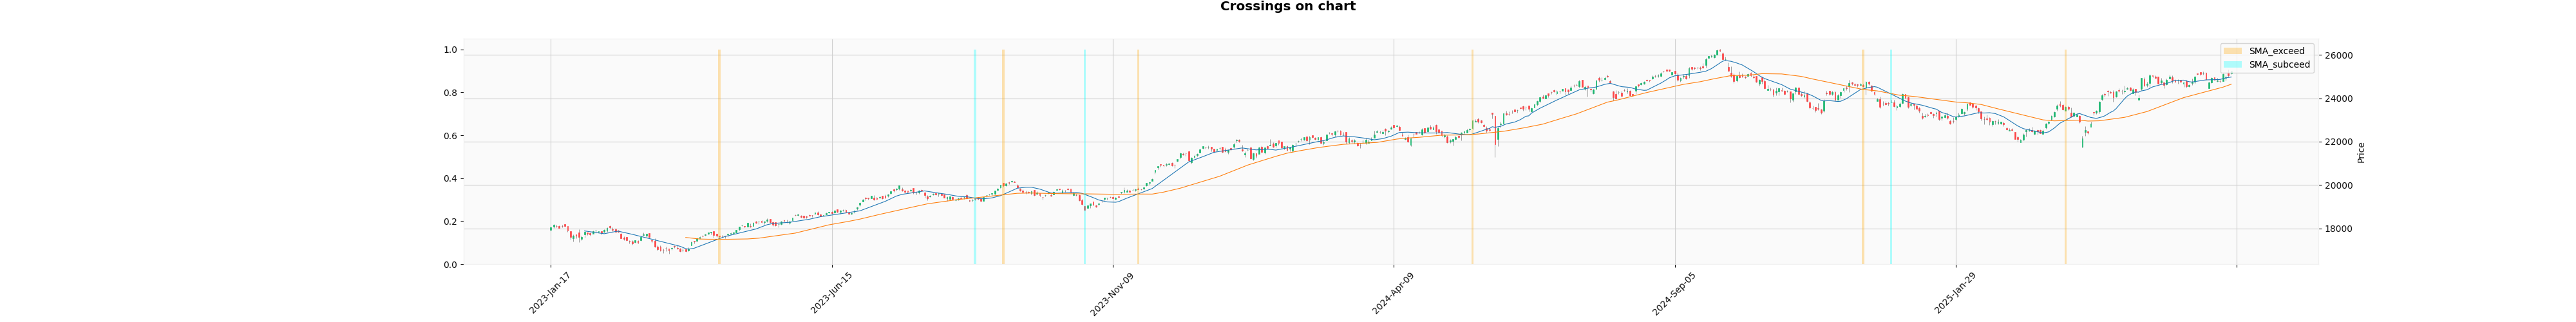

In [61]:
s_title     = 'Crossings on chart'
li_mav      = [i_short, i_long]
df_subset   = get_subset_to_plot(df_simpler)
li_addplots = [   append_pattern(df_simpler, 'SMA_exceed',  'orange'),
                  append_pattern(df_simpler, 'SMA_subceed', 'cyan')
              ]
plot_chart(df_simpler, s_title, li_mav, li_addplots, bo_add_Volume=False, i_width=40, i_height=5)

In [45]:
print('Balance=', get_balance(df_simpler, 'Close', 'SMA_exceed', 'SMA_subceed') )

sold_qty= 17 bought_qty= 24
current_total= 176708
last_price= 25244
sold_total= 327956 bought_total= 468937
Balance= 35727


#### Optimisation

# ToDo : 
- add interest rate average calculation
- implement ML w/ train-validate-test partition & feature engineering

In [46]:
def get_2_SMAs_balance(df_in, i_short, i_long, sr_close) :
        sr_short = ta.SMA(sr_close, timeperiod=i_short)
        sr_long  = ta.SMA(sr_close, timeperiod=i_long)
        df_simpler['SMA_exceed'], df_in['SMA_subceed'] = get_crossings(sr_short, sr_long)
        return get_balance(df_in, 'Close', 'SMA_exceed', 'SMA_subceed', bo_verbose=False)     

In [47]:
li_results = []  # list of tuples (short period, long period, balance)
for i_short in range(3, 14) :
    for i_long in range(15, 50) :
        i_balance = get_2_SMAs_balance(df_simpler, i_short, i_long, sr_close)
        if i_balance > 0 : li_results.append( (i_short, i_long, i_balance) ) 
sorted(li_results, key=lambda x:x[2], reverse=True)[:10] # get top balance amounts

[(13, 15, 254416),
 (13, 16, 156313),
 (12, 15, 127641),
 (11, 24, 80240),
 (11, 25, 67696),
 (8, 25, 65508),
 (10, 25, 63576),
 (9, 26, 58016),
 (5, 25, 55215),
 (12, 26, 53968)]

### Volatility Index

In [48]:
s_stock_ref = '^VIX'
df_vix = yf.download(s_stock_ref, interval=s_interval, period=s_period)

[*********************100%***********************]  1 of 1 completed


In [49]:
df_simpler['VIX'] = df_vix['Close'].shift(1)

In [50]:
# Replace null values at 1st rows after shift
d_1st_vix = df_vix.index[0]
f_1st_vix = df_vix.loc[d_1st_vix, 'Close']
df_simpler.loc[:d_1st_vix, 'VIX'] = f_1st_vix.iloc[0]

In [51]:
df_simpler['VIX'].head()

Date
2020-06-25    32.220001
2020-06-26    32.220001
2020-06-29    34.730000
2020-06-30    31.780001
2020-07-01    30.430000
Name: VIX, dtype: float64

In [52]:
s_title     = 'Volatility on chart'
li_mav      = [] #[i_short, i_long]
li_addplots = [ mpf.make_addplot(df_subset[['VIX']], type='line', color='green') ]
plot_chart(df_subset, s_title, li_mav, li_addplots, bo_add_Volume=False, i_width=40, i_height=5)

KeyError: "None of [Index(['VIX'], dtype='object')] are in the [columns]"